In [4]:
import nltk
import math
import dill
from collections import defaultdict
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, fbeta_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
nltk.download('brown')
nltk.download('universal_tagset')
from nltk.corpus import brown

[nltk_data] Downloading package brown to /home/parth/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/parth/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [6]:
Vocab = len(set([str(k[0]).lower() for k in brown.tagged_words()]))

In [7]:
tagged_sentences = brown.tagged_sents(tagset='universal')
all_tags = list(set([tag for sentence in tagged_sentences for _, tag in sentence]))

In [8]:
def convert_to_standard_dtype(tagged_sentences):
    _tagged_sentences = []
    for sentence in tagged_sentences:
        _tagged_sentences.append([])
        for word,tag in sentence:
            _tagged_sentences[-1].append([word, tag])
    return _tagged_sentences

In [9]:
tagged_sentences = convert_to_standard_dtype(tagged_sentences)

In [10]:
class HiddenMarkovModel:
    
    def __init__(self, sentences = [], k_smoothing = 0, START_DELIM = '^' , LOW_PROB = 1e-18):
        self.sentences = sentences
        self._find_tags()
        self.k_smoothing = k_smoothing
        self.all_tags = all_tags
        self.START_DELIM = START_DELIM
        self.LOW_PROB = LOW_PROB
        self.compute_transition_probabilities()
        self.compute_emmision_probabilities()
    
    def _find_tags(self):
        self.tags = list(set( [ word_tag[1] for sentence in tagged_sentences for word_tag in sentence ] ))
    
    def compute_transition_probabilities(self):
        T = defaultdict(lambda: defaultdict(lambda:0))
        # T = dict of dicts
        # T[tcurr] = dict
        # T[tcurr][tprev] = integer with default value as 0
        TC = defaultdict(lambda : 0)
        # TC (tag count) = dict
        # TC[tag] = integer with default value as 0

        
        for sentence in self.sentences:
            # skip first word for now
            prev_word = (self.START_DELIM, self.START_DELIM)
            for word in sentence:
                T[word[1]][prev_word[1]] += 1
                TC[word[1]] += 1
                prev_word = word
        
        TC[self.START_DELIM] = len(self.sentences)

        for curr_tag in T:
            for prev_tag in T[curr_tag]:
                if prev_tag == self.START_DELIM:
                    T[curr_tag][prev_tag] = T[curr_tag][prev_tag] / TC[prev_tag]
                else:
                    T[curr_tag][prev_tag] = (T[curr_tag][prev_tag] + self.k_smoothing) / (TC[prev_tag] + (len(self.tags) * self.k_smoothing))
        
        self.T = T
        self.TC = TC
    
    def compute_emmision_probabilities(self):
        E = defaultdict(lambda: defaultdict(lambda:self.k_smoothing))
        # W = dict of dicts
        # W[word] = dict
        # W[word][tag] = integet with default value as 0        

        for sentence in self.sentences:
            for word in sentence:
                E[word[0]][word[1]] += 1

        for word in E.keys():
            for tag in E[word].keys():
                E[word][tag] = E[word][tag] / (self.TC[tag] + (Vocab * self.k_smoothing))

        self.E = E

    def word_given_tag(self, word, tag):
        if word in self.E and tag in self.E[word]:
            return self.E[word][tag]
        else:
            if self.k_smoothing == 0:
                return self.LOW_PROB
            else:
                return (self.k_smoothing / (self.TC[tag] + Vocab*self.k_smoothing))
        

    def trans(self, curr_tag, prev_tag):
        if curr_tag in self.T and prev_tag in self.T[curr_tag]:
            return self.T[curr_tag][prev_tag]
        else:
            if self.k_smoothing == 0:
                return self.LOW_PROB
            else:
                return (self.k_smoothing / (self.TC[prev_tag] + len(self.tags)*self.k_smoothing))
            
            


In [11]:
class POSTaggerModel:
    def __init__(self, sentences, k_smoothing=0):
        self.sentences = sentences
        self.k_smoothing = k_smoothing
        self.hmm = None

    """
    Input : [w1, w2 , ... , wwn]
    Output : [ (w1,t1) , (w2,t2) , .... , (wn , tn) ]
    Space Complexity : O(|W||T|)
    Time Complexity : O(|W||T|^2)
    """
    def Viterbi(self, words):
        
        def LP(probability):
            return math.log(probability)
            
        START_DELIM = self.hmm.START_DELIM
        
        V_lpprobability = defaultdict(lambda: 0)
        V_path = defaultdict(lambda: START_DELIM)
        
        for tag in self.hmm.all_tags:
            V_lpprobability[tag] = LP(self.hmm.trans(tag,START_DELIM)) + LP(self.hmm.word_given_tag(words[0],tag))
            V_path[tag] = [ START_DELIM , tag ]
        
        for word in words[1:]:
            t_lpprobability = defaultdict(lambda: None)
            t_path = defaultdict(lambda: [])
            for curr_tag in self.hmm.all_tags:
                for prev_tag in self.hmm.all_tags:
                    curr_prob = V_lpprobability[prev_tag] + LP(self.hmm.trans(curr_tag,prev_tag)) + LP(self.hmm.word_given_tag(word,curr_tag))
                    if not curr_tag in t_lpprobability or curr_prob > t_lpprobability[curr_tag]:
                        t_lpprobability[curr_tag] = curr_prob
                        t_path[curr_tag] = V_path[prev_tag] + [curr_tag]

            V_path = t_path
            V_lpprobability = t_lpprobability
        
        max_prob_ending_tag = max(V_lpprobability , key=V_lpprobability.get)
        max_prob_path = V_path[max_prob_ending_tag]
        
        return zip(words, max_prob_path[1:])

    def pre_process(self, word):
        return word.lower()

    def tokenizer(self, sentence_str):
        words = [""]
        take = True
        for c in sentence_str:
            if c == ' ':
                take = False
                continue
            
            if not take or not c.isalnum() :
                words.append(c)
                if c.isalnum():
                    take = True
                else:
                    take = False
            else :
                words[-1] += c
                
        return words
    
    def fit(self):
        for i in range(len(self.sentences)):
            for j in range(len(self.sentences[i])):
                word = self.sentences[i][j][0]
                self.sentences[i][j][0] = self.pre_process(word)
                
        self.hmm = HiddenMarkovModel(self.sentences, k_smoothing = self.k_smoothing)
    
    def predict(self,sentence_str):
        words = [self.pre_process(word) for word in self.tokenizer(sentence_str) ]
        return self.Viterbi(words)
        


In [12]:
class Fold5CrossValidate:

    def __init__(self, title,k_smoothing = 0):
        self.k_smoothing = k_smoothing
        self.title = title

    def start(self):
        NUM_FOLDS = 5
        kf = KFold(NUM_FOLDS , shuffle=  True, random_state=42)
        k_smoothing = self.k_smoothing
        title = self.title
        accuracies = []
        all_true_tags = []
        all_predicted_tags = []
        models = []
        per_fold = []
        reports = []
        iteration = 1
        for train_indices, test_indices in kf.split(tagged_sentences):
            train_data = [tagged_sentences[i] for i in train_indices]
            test_data = [tagged_sentences[i] for i in test_indices]
        
            model = POSTaggerModel(train_data, k_smoothing=k_smoothing)
            model.fit()
            
            true_tags = []
            predicted_tags = []
            
            for sentence in test_data:
                true_tags += [word[1] for word in sentence]
                prediction = model.Viterbi([word[0].lower() for word in sentence])
                predicted_tags += [tag for word,tag in list(prediction)]

            all_true_tags += true_tags
            all_predicted_tags += predicted_tags
            
            reports.append(classification_report(y_true=true_tags, y_pred=predicted_tags, labels=all_tags))
            
            curr_model_accuracy = accuracy_score(true_tags, predicted_tags)
            
            accuracies.append(curr_model_accuracy)
            models.append(model)
        
            print(f"Accuracy for {title} Model-{iteration} : {curr_model_accuracy}")
            iteration += 1
            
            per_fold.append({
                "f0.5_score" : fbeta_score(true_tags, predicted_tags, beta=0.5, average='weighted',zero_division=0), 
                "f1_score" : fbeta_score(true_tags, predicted_tags, beta=1, average='weighted',zero_division=0), 
                "f2_score" : fbeta_score(true_tags, predicted_tags, beta=2, average='weighted',zero_division=0), 
                "precision" : precision_score(true_tags, predicted_tags,average='weighted',zero_division=0),
                "recall" : recall_score(true_tags, predicted_tags,average='weighted',zero_division=0),
            })
        
        mean_accuracy = np.mean(accuracies)
        std_dev_accuracy = np.std(accuracies)

        stats = defaultdict(lambda: 0)
        stats_keys = per_fold[0].keys()
        for stat in stats_keys:
            for f in per_fold:
                stats[stat] += f[stat]
            stats[stat] /= 5
        
        self.accuracies = accuracies
        self.models = models
        self.reports = reports
        self.mean_accuracy = mean_accuracy
        self.std_dev_accuracy = std_dev_accuracy
        self.statistics = stats
        self.overall_report = classification_report(y_true=all_true_tags, y_pred=all_predicted_tags, labels=all_tags)
        self.confusion_mat = confusion_matrix(all_true_tags, all_predicted_tags, labels=all_tags)


In [13]:
a_hmm_vit = Fold5CrossValidate("0-smoothing", k_smoothing=0)
a_hmm_vit.start()

Accuracy for 0-smoothing Model-1 : 0.9608497501368966
Accuracy for 0-smoothing Model-2 : 0.9606550596507555
Accuracy for 0-smoothing Model-3 : 0.9605235747517533
Accuracy for 0-smoothing Model-4 : 0.9601059081229614
Accuracy for 0-smoothing Model-5 : 0.9601079644898045


In [14]:
b_hmm_vit = Fold5CrossValidate("1-smoothing", k_smoothing=1)
b_hmm_vit.start()

Accuracy for 1-smoothing Model-1 : 0.9386401755724861
Accuracy for 1-smoothing Model-2 : 0.9387335685757493
Accuracy for 1-smoothing Model-3 : 0.9377603985834317
Accuracy for 1-smoothing Model-4 : 0.9380402642477345
Accuracy for 1-smoothing Model-5 : 0.9377475064841955


In [15]:
def printBasicStats(model):
    print(f"F-0.5 Score : {model.statistics["f0.5_score"]}")
    print(f"F-1 Score : {model.statistics["f1_score"]}")
    print(f"F-2 Score : {model.statistics["f2_score"]}")
    print(f"Precision : {model.statistics["precision"]}")
    print(f"Recall : {model.statistics["recall"]}")

In [16]:
printBasicStats(a_hmm_vit)

F-0.5 Score : 0.9603247727120658
F-1 Score : 0.9603257123309966
F-2 Score : 0.9603822064728055
Precision : 0.9603584545615714
Recall : 0.9604484514304342


In [17]:
printBasicStats(b_hmm_vit)

F-0.5 Score : 0.9382093844259826
F-1 Score : 0.9377524780888382
F-2 Score : 0.9378422606022664
Precision : 0.9388669602106876
Recall : 0.9381843826927193


In [18]:
print(f"Overall(Mean) Accuracy (5-Fold Cross-Validation): {a_hmm_vit.mean_accuracy :.4f}")
print(f"Standard Deviation of Model Accuracy (5-Fold Cross-Validation): {a_hmm_vit.std_dev_accuracy:.4f}")

Overall(Mean) Accuracy (5-Fold Cross-Validation): 0.9604
Standard Deviation of Model Accuracy (5-Fold Cross-Validation): 0.0003


In [19]:
print(f"Overall(Mean) Accuracy (5-Fold Cross-Validation): {b_hmm_vit.mean_accuracy :.4f}")
print(f"Standard Deviation of Model Accuracy (5-Fold Cross-Validation): {b_hmm_vit.std_dev_accuracy:.4f}")

Overall(Mean) Accuracy (5-Fold Cross-Validation): 0.9382
Standard Deviation of Model Accuracy (5-Fold Cross-Validation): 0.0004


In [20]:
print(a_hmm_vit.overall_report)

              precision    recall  f1-score   support

        VERB       0.97      0.95      0.96    182750
        NOUN       0.96      0.96      0.96    275558
        CONJ       0.99      0.99      0.99     38151
        PRON       0.96      0.98      0.97     49334
         NUM       0.97      0.92      0.94     14874
         DET       0.97      0.99      0.98    137019
         PRT       0.90      0.90      0.90     29829
         ADV       0.91      0.90      0.90     56239
         ADP       0.95      0.97      0.96    144766
           .       1.00      1.00      1.00    147565
           X       0.74      0.53      0.61      1386
         ADJ       0.92      0.91      0.92     83721

    accuracy                           0.96   1161192
   macro avg       0.94      0.92      0.93   1161192
weighted avg       0.96      0.96      0.96   1161192



In [21]:
print(b_hmm_vit.overall_report)

              precision    recall  f1-score   support

        VERB       0.97      0.91      0.94    182750
        NOUN       0.95      0.92      0.93    275558
        CONJ       0.99      0.99      0.99     38151
        PRON       0.90      0.96      0.93     49334
         NUM       0.99      0.80      0.88     14874
         DET       0.92      0.99      0.95    137019
         PRT       0.91      0.85      0.88     29829
         ADV       0.89      0.87      0.88     56239
         ADP       0.91      0.97      0.94    144766
           .       0.98      1.00      0.99    147565
           X       0.73      0.31      0.43      1386
         ADJ       0.87      0.89      0.88     83721

    accuracy                           0.94   1161192
   macro avg       0.92      0.87      0.89   1161192
weighted avg       0.94      0.94      0.94   1161192



In [22]:
def plot_confusion_matrix(cf_matrix):
    fig, ax = plt.subplots(figsize=(13,10))     
    cf_matrix = cf_matrix / np.sum(cf_matrix, axis=1, keepdims=True)
    sns.heatmap(cf_matrix, fmt='.2%', annot=True, linewidths=1, ax=ax, cmap='Blues', xticklabels=all_tags, yticklabels=all_tags)
    ax.set_xlabel("Predicted Tags")
    ax.set_ylabel("True Tags")

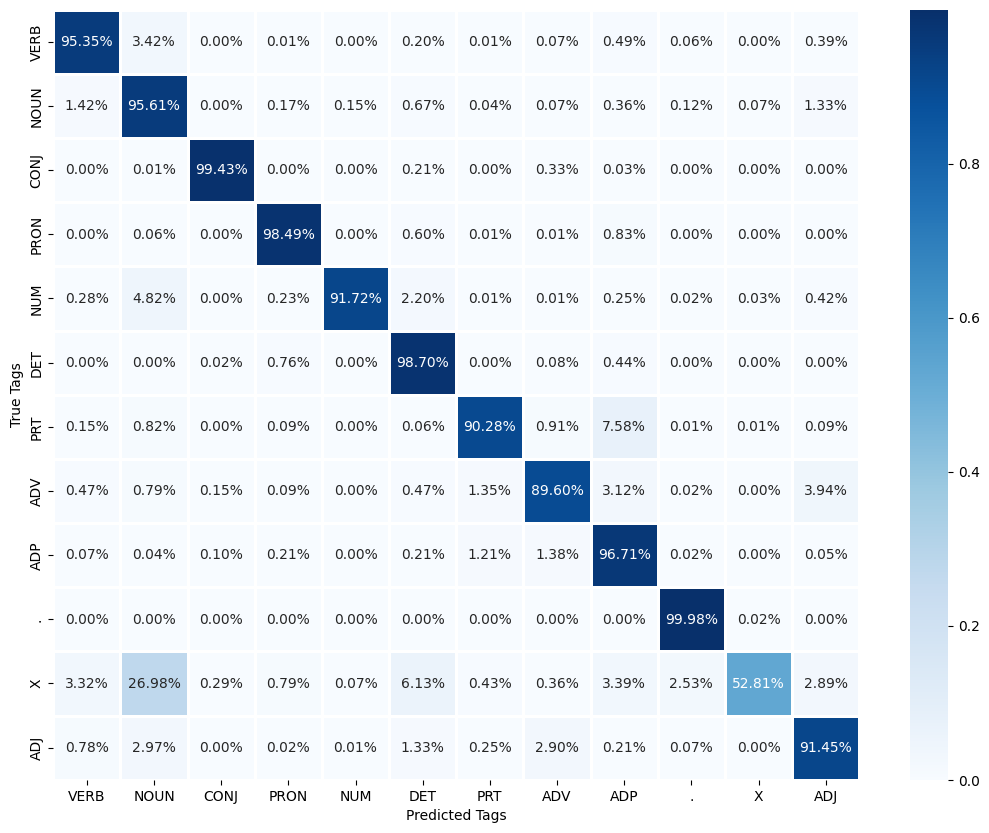

In [23]:
plot_confusion_matrix(a_hmm_vit.confusion_mat)

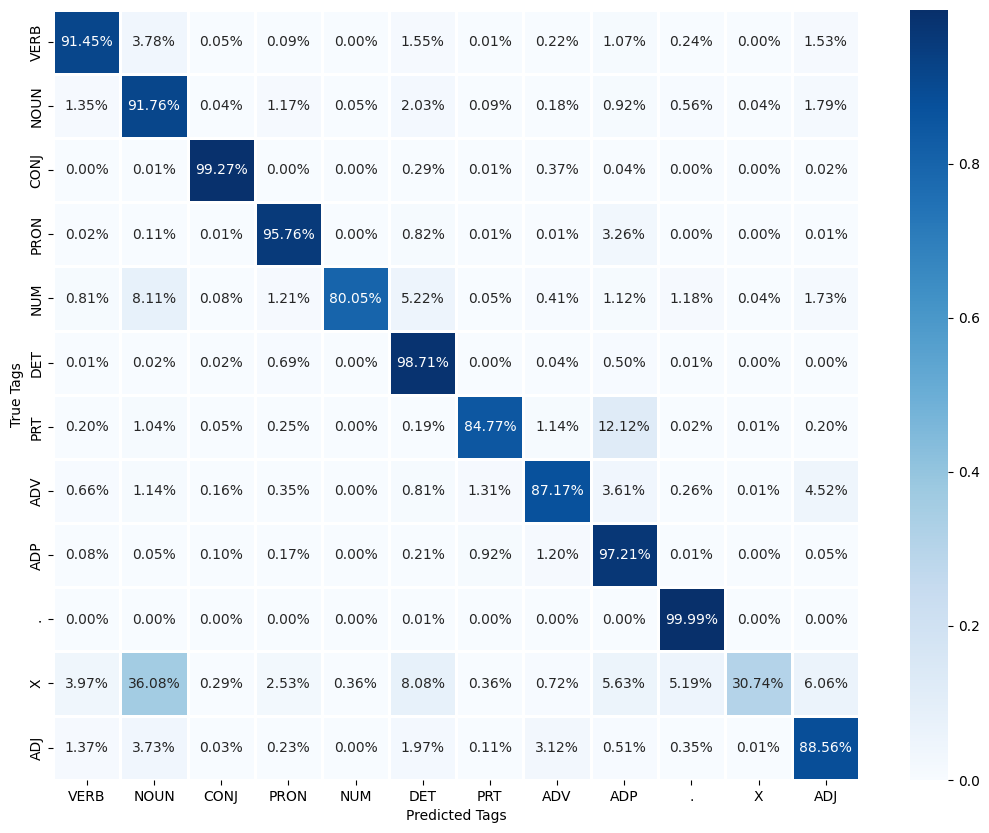

In [24]:
plot_confusion_matrix(b_hmm_vit.confusion_mat)

In [29]:
def plot_accuracy_bars(model):
    cf_matrix = model.confusion_mat
    get_count_of_tags = lambda tag: len()
    tgs = model.models[0].hmm.tags
    per_tag_accuracy = [ round((cf_matrix[i][i] / np.sum(cf_matrix[i]))*100,2) for i in range(len(tgs)) ]
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(tgs , per_tag_accuracy, label=tgs)
    for i in range(len(tgs)):
        ax.text(i-0.4, per_tag_accuracy[i]+1, f"{per_tag_accuracy[i]}%")
    ax.set_xlabel("POS Tags")
    ax.set_ylabel("Accuracy %")


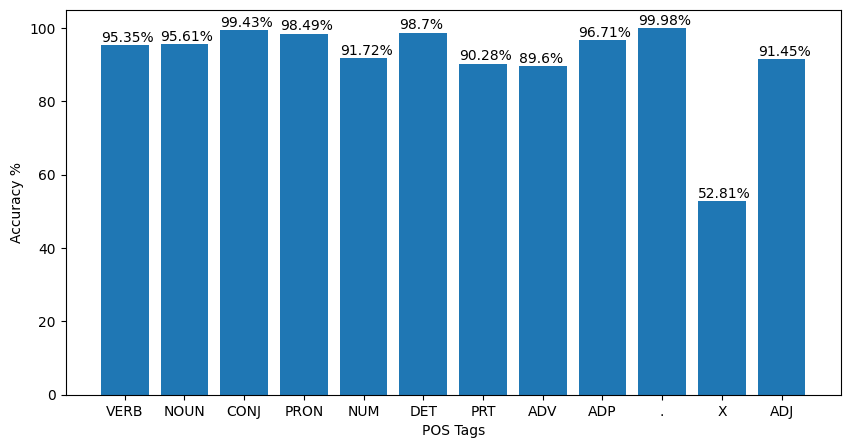

In [30]:
plot_accuracy_bars(a_hmm_vit)

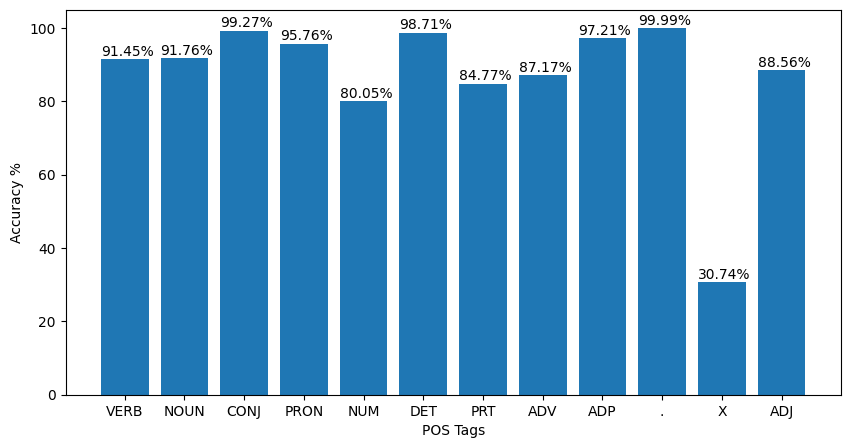

In [32]:
plot_accuracy_bars(b_hmm_vit)

In [34]:
model = POSTaggerModel(list(tagged_sentences), k_smoothing=0)
model.fit()

In [35]:
# Final model to export 
print("Saving Model...", end ='')
with open("pos-tagger-0smth.pkl", "wb") as f:
    dill.dump(model, f)
print("Saved !")

Saving Model...Saved !


In [36]:
model = POSTaggerModel(list(tagged_sentences), k_smoothing=1)
model.fit()

In [37]:
# Final model to export 
print("Saving Model...", end ='')
with open("pos-tagger-1smth.pkl", "wb") as f:
    dill.dump(model, f)
print("Saved !")

Saving Model...Saved !
